In [6]:
# Step 1: Imports and basic setup

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)


In [7]:
# Step 2: Load and clean full dataset

file_path = "../data/raw/online_retail_II.xlsx"
df = pd.read_excel(file_path, sheet_name="Year 2010-2011")

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with missing critical data
df = df.dropna(subset=['Price', 'Quantity', 'InvoiceDate'])

# Convert types
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Remove invalid data
df = df[(df['Price'] > 0) & (df['Quantity'] > 0)]

# Reset index
df = df.reset_index(drop=True)

# Quick summary stats
print("Dataset shape after cleaning:", df.shape)
df[['Price', 'Quantity']].describe()

Missing values per column:
 Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64
Dataset shape after cleaning: (530105, 8)


,Price,Quantity
count,530105.000000,530105.000000
mean,3.907652,10.542019
std,35.915652,155.523977
min,0.001000,1.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,13541.330000,80995.000000


In [5]:
## Step 2: Check and clean the full dataset

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows where critical fields are missing
df = df.dropna(subset=['Price', 'Quantity', 'InvoiceDate'])

# Convert data types
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Drop rows where conversion failed (NaT or NaN)
df = df.dropna(subset=['Price', 'Quantity', 'InvoiceDate'])

# Optional: remove rows with negative quantities or prices
df = df[(df['Price'] > 0) & (df['Quantity'] > 0)]

# Reset index
df = df.reset_index(drop=True)

# Quick summary stats
print("Dataset shape after cleaning:", df.shape)
print(df[['Price', 'Quantity']].describe())

# Display first 5 rows to confirm
df.head()


Missing values per column:
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64
Dataset shape after cleaning: (530105, 8)
               Price       Quantity
count  530105.000000  530105.000000
mean        3.907652      10.542019
std        35.915652     155.523977
min         0.001000       1.000000
25%         1.250000       1.000000
50%         2.080000       3.000000
75%         4.130000      10.000000
max     13541.330000   80995.000000


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
# Step 3: Add Profit column and random promotions for demo

# Calculate profit per row
df['Profit'] = df['Quantity'] * df['Price']

# Randomly assign promotions
np.random.seed(42)
df['Promotion'] = np.random.choice(['No_Discount', 'Discount_5%', 'Discount_10%'], size=len(df))

# Extract day of week
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name().str[:3]

# Show first few rows
df[['StockCode','Price','Quantity','Promotion','Profit','DayOfWeek']].head()


,StockCode,Price,Quantity,Promotion,Profit,DayOfWeek
0,85123A,2.55,6,Discount_10%,15.30,Wed
1,71053,3.39,6,No_Discount,20.34,Wed
2,84406B,2.75,8,Discount_10%,22.00,Wed
3,84029G,3.39,6,Discount_10%,20.34,Wed
4,84029E,3.39,6,No_Discount,20.34,Wed


In [9]:
# Step 4: Compute historical profit multiplier for DayOfWeek

# Group by DayOfWeek and compute mean profit
day_profit_avg = df.groupby('DayOfWeek')['Profit'].mean()

# Normalize to overall mean for multipliers
overall_mean = df['Profit'].mean()
day_multiplier = (day_profit_avg / overall_mean).to_dict()

print("Day of Week multipliers:", day_multiplier)


Day of Week multipliers: {'Fri': 1.139241772768415, 'Mon': 0.9495775540504725, 'Sun': 0.632891549965904, 'Thu': 1.0839931213513614, 'Tue': 1.0885973215496316, 'Wed': 0.9965533186841459}


In [10]:
# Step 5: Define hyperparameters for Bayesian Optimization

search_space = [
    Real(0.5, 2.0, name='Price_Multiplier'),                     # Continuous
    Categorical(['No_Discount','Discount_5%','Discount_10%'], name='Promotion'), # Categorical
    Integer(1, 20, name='Bundle_Size'),                           # Integer
    Categorical(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], name='DayOfWeek'), # Categorical
    Real(0, 20, name='Max_Discount_Percent')                     # Continuous
]


In [11]:
# Step 6: Objective function for Bayesian optimization
@use_named_args(search_space)
def objective(**params):
    price_multiplier = params['Price_Multiplier']
    promotion = params['Promotion']
    bundle_size = params['Bundle_Size']
    day = params['DayOfWeek']
    max_discount = params['Max_Discount_Percent']
    
    # Adjust price
    df['AdjPrice'] = df['Price'] * price_multiplier
    
    # Map promotion to discount
    discount_map = {'No_Discount':0, 'Discount_5%':5, 'Discount_10%':10}
    applied_discount = min(discount_map[promotion], max_discount)
    
    # Apply final price
    df['FinalPrice'] = df['AdjPrice'] * (1 - applied_discount/100)
    
    # Apply bundle size
    df['EstimatedProfit'] = df['Quantity'] * df['FinalPrice'] * bundle_size
    
    # Apply day-of-week multiplier
    df['EstimatedProfit'] *= df['DayOfWeek'].map(day_multiplier)
    
    # Maximize profit → minimize negative
    return -df['EstimatedProfit'].sum()


In [12]:
# Step 7: Run Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=30,          # Number of evaluations
    random_state=42,
    verbose=True
)

print("Best hyperparameters found:")
for dim, val in zip(search_space, result.x):
    print(f"{dim.name}: {val}")

print("\nMaximum estimated profit:", -result.fun)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0803
Function value obtained: -295742546.7395
Current minimum: -295742546.7395
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0352
Function value obtained: -47139125.4769
Current minimum: -295742546.7395
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0309
Function value obtained: -109028361.1353
Current minimum: -295742546.7395
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0363
Function value obtained: -14776870.8289
Current minimum: -295742546.7395
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0295
Function value obtain

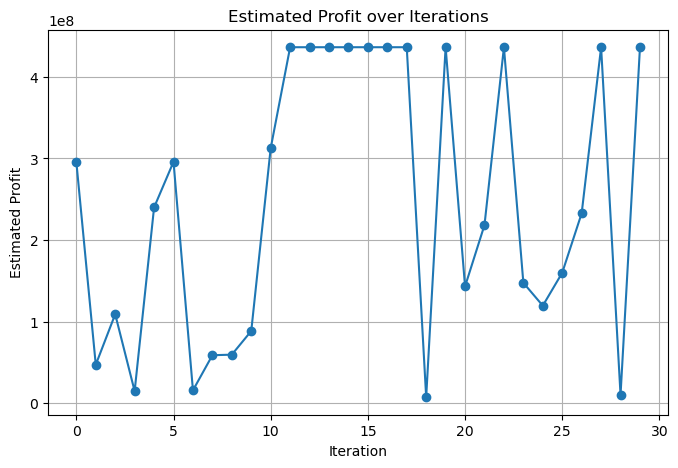

In [13]:
# Step 8: Visualize estimated profit vs. iterations
plt.figure(figsize=(8,5))
plt.plot(-np.array(result.func_vals), marker='o')
plt.title("Estimated Profit over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Estimated Profit")
plt.grid(True)
plt.show()
